divide input raster into image chips of defined size (e.g. 224)
useful when dividing larger raster into regular shapes

### create image chips

In [1]:
import numpy as np
import os 
import rasterio as rs 
from pathlib import Path

In [16]:
#@title Parameters
#work_dir = Path('/home/lucie/GDA_UGS/ESA_GDA_UGS/Freetown/input_data_Phase3/17')

#tile = '23'

base_dir = Path('/home/lucie/GDA_UGS/ESA_GDA_UGS/GDA_urban/Phase2')
#base_dir = Path('/home/lucie/GDA_UGS/ESA_GDA_UGS/Kinshasa/01_processing_testing')
#work_dir = base_dir.joinpath('input_data_Phase3_predict',tile)
#work_dir = base_dir.joinpath('labels_test2',tile)
work_dir = base_dir.joinpath('model_input')

os.chdir(work_dir)

# the imagery and labels should be inside the work_dir 
#imagery = f"img_tile{tile}.tif"
#label = f"lbl_tile{tile}.tif"
imagery = 'imagery_clip_3808m_GRNIR.tif'
label = 'labels_test.tif'

stride=448
winsize=448

zfill_value = 4 #length of the numbering convention (e.g.0001)

In [3]:
def trainchips_single(img, zfill_value, index_start=0, stride=224, winsize=224, variant='img'):
    
    '''
    (stride = winsize/2 >> get 50% overlap)
    (depends on model input size, e.g. imagenet uses 224 or 256 pixels)
    
    variant - when creating image chips for labels, variant='lbl'
    '''
    
    image= rs.open(img)
    imgarr=image.read()
    print("Shape of training data  is: ",imgarr.shape) 
    invarr= image.read(1)

    index=index_start
    
    for i in np.arange(0,imgarr.shape[1],stride):
        for j in np.arange(0,imgarr.shape[2],stride):
            img=imgarr[:,i:i+winsize,j:j+winsize]
            x,y = (j*image.transform[0]+image.transform[2]),(image.transform[5]+i*image.transform[4])
            transform= [image.transform[0],0,x,0,image.transform[4],y]
            index+=1
            
            if variant=='img':
                with rs.open(str(index).zfill(zfill_value)+"_img.tif","w",driver='GTiff', count=imgarr.shape[0], dtype=imgarr.dtype,
                         width=winsize, height=winsize, transform=transform, crs=image.crs) as raschip:
                         raschip.write(img)
            elif variant=='lbl':
                with rs.open(str(index).zfill(zfill_value)+"_lbl.tif","w",driver='GTiff', count=imgarr.shape[0], dtype=imgarr.dtype,
                         width=winsize, height=winsize, transform=transform, crs=image.crs) as raschip:
                         raschip.write(img)
                        
    print("The number of image chips is: ", index-index_start)

In [17]:
#trainchips_single(imagery,zfill_value=zfill_value,stride=stride, winsize=winsize)
trainchips_single(label,zfill_value=zfill_value,stride=stride, winsize=winsize,variant='lbl')

Shape of training data  is:  (1, 7616, 7616)
The number of image chips is:  289


### organize files

distribute the created image chips into img and lbl folders

In [18]:
# create img & lbl directories

dst_img = work_dir.joinpath('img')
dst_lbl = work_dir.joinpath('lbl')

def create_dir(path):
    if os.path.exists(path) == False:
        os.makedirs(path)
        
create_dir(dst_img)
create_dir(dst_lbl)

In [19]:
# split img chips into files by "lbl" and "img"
import shutil

for file_item in os.listdir(work_dir):
    if "_img" in file_item:
        src_img=work_dir.joinpath(file_item)
        shutil.move(src_img, dst_img)
    elif "_lbl" in file_item:
        src_lbl=work_dir.joinpath(file_item)
        shutil.move(src_lbl, dst_lbl)
    else:
        continue

### plots (optional)

Shape of training data  is:  (1, 4000, 4000)
**** number of sample pixels for each class ****


<BarContainer object of 8 artists>

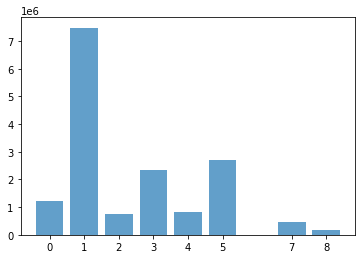

In [65]:
#img = r"/home/lucie/GDA_UGS/ESA_GDA_UGS/Freetown/input_data_Phase3/8/lbl_tile8.tif"
img = base_dir.joinpath('input_data_Phase3',tile,f'lbl_tile{tile}.tif')

image= rs.open(img)
imgarr=image.read()
print("Shape of training data  is: ",imgarr.shape) 
invarr= image.read(1)

i,j = np.unique(invarr, return_counts= True)
print("**** number of sample pixels for each class ****")
plt.bar(i, j,alpha=0.7, tick_label=i)

In [66]:
import csv

#src: https://www.pythontutorial.net/python-basics/python-write-csv-file/
csv_path = base_dir.joinpath('class_distribution.csv')

header=['tile','other','low_veg_active','low_veg_inactive','high_veg_shrub','bare_soil','high_veg_trees','water','buildings','roads']
  
#data = [version,kernel_size,n_epochs_real,batch_size,weights,num_classes,early_stopping.monitor,early_stopping.patience,shape,current_date,train_input_size_orig,num_training_samples,str(config.__dict__),note]
data = [tile,*j] #asterisk >> array without brackets (src: https://blog.finxter.com/how-to-print-a-numpy-array-without-brackets-in-python/)
print(data)

if os.path.exists(csv_path):
    with open(csv_path, 'a') as f:
        writer = csv.writer(f)
        writer.writerow(data)
else:
    with open(csv_path, 'w', encoding='UTF8') as f:
        writer = csv.writer(f)

        # write the header
        writer.writerow(header)

        # write the data
        writer.writerow(data)

['24', 1237112, 7479167, 766519, 2350795, 813870, 2716990, 465553, 169994]
